# Settings

In [243]:
from pathlib import Path

import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

In [244]:
syntanic_data_path = Path(r'.\data\train.csv')
syntanic_data = pd.read_csv(syntanic_data_path, index_col='PassengerId')
ports_of_embarkation = ['Southampton', 'Cherbourg', 'Queenstown']
syntanic_data['Embarked'].replace(
      {p[0]: p for p in ports_of_embarkation},
      inplace=True)

syntanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,Southampton
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,Southampton
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,Southampton
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,Southampton
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,Southampton


# Context

Здесь использован синтетический набор данных, но основан на реальных данных с Титаника.

В данных следующие колонки: ``` ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] ```, а ```'PassengerId'``` использован как индекс строки.

# Data quality assessment

Количество строк (пассажиров) в данных 100000


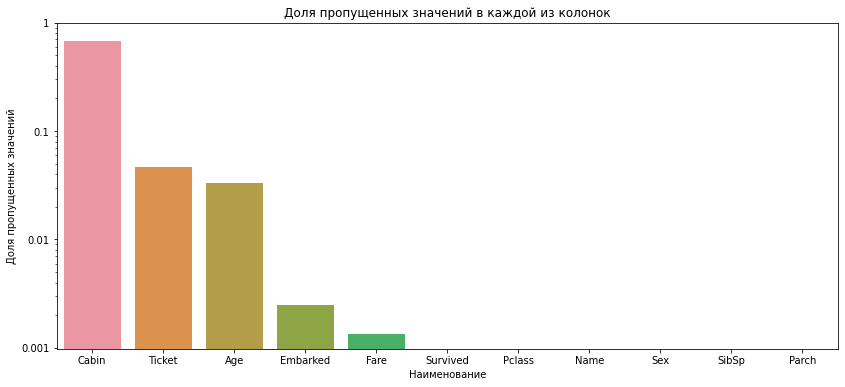

Среди колонок наибольшее количество пропущенных значений имеет номер кабины ('Cabin' = 67.87%), далее номер билета ('Ticket' = 4.62%) и возраст ('Age' = 3.29%), а наименьшее - порт назначения ('Embarked' = 0.25%) и тариф ('Fare' = 0.13%). В остальных колонках нет пропущенных значений.
При этом во всем датасете обнаружено 0 полностью пустых строк


In [245]:
total_rows = syntanic_data.shape[0]
print(f'Количество строк (пассажиров) в данных {syntanic_data.shape[0]}')

plt.figure(figsize=(14, 6))
plt.title('Доля пропущенных значений в каждой из колонок')

na_fraction = (syntanic_data.isna().sum() / total_rows).sort_values(ascending=False)
na_frac_fig = sb.barplot(x=na_fraction.index, y=na_fraction)
na_frac_fig.set(xlabel='Наименование', ylabel='Доля пропущенных значений')
na_frac_fig.set_yscale("log")
na_frac_fig.set_yticks([0.001, 0.01, 0.1, 1])
na_frac_fig.set_yticklabels([0.001, 0.01, 0.1, 1])
plt.show()

print('Среди колонок наибольшее количество пропущенных значений имеет '
      'номер кабины (\'Cabin\' = {:.2%}), далее номер билета '
      '(\'Ticket\' = {:.2%}) и возраст (\'Age\' = {:.2%}), '
      'а наименьшее - порт назначения (\'Embarked\' = {:.2%}) '
      'и тариф (\'Fare\' = {:.2%}). В остальных колонках '
      'нет пропущенных значений.'\
      .format(na_fraction['Cabin'], na_fraction['Ticket'], na_fraction['Age'],
              na_fraction['Embarked'], na_fraction['Fare']))
print('При этом во всем датасете обнаружено {:d} полностью пустых строк'\
      .format(total_rows - syntanic_data.dropna(how='all').shape[0]))

Датасет имеет 0 строк-дубликатов


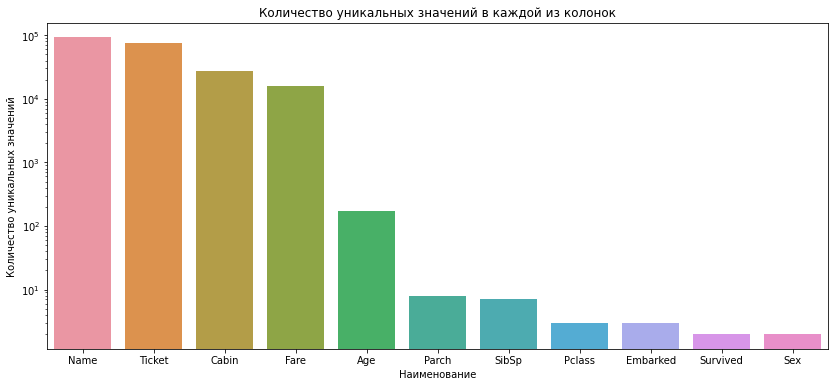

При расчете отсутвующие значения отбрасывались. Среди данных уникальных имен 92144, номеров билетов 75331 (самый часто встречающийся билет - 'A/5 ' (601 раз)), номеров кают 26992 (что логично, так как каюты бывают многоместные и также в этих данных больше всего отсутствующих значений)
Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается предположение, что в этом поле много невалидных данных. В дальнейшем обработка может проводиться только по уникальным номерам билетов (о чем будет написано)


In [246]:
print('Датасет имеет {:d} строк-дубликатов'\
      .format(syntanic_data[syntanic_data.duplicated()].shape[0]))

plt.figure(figsize=(14, 6))
plt.title('Количество уникальных значений в каждой из колонок')

unique_values_count = syntanic_data.nunique(dropna=True).sort_values(ascending=False)
unique_vals_fig = sb.barplot(x=unique_values_count.index, y=unique_values_count)
unique_vals_fig.set(xlabel='Наименование', ylabel='Количество уникальных значений')
unique_vals_fig.set_yscale("log")
plt.show()

duplicated_tickets = syntanic_data['Ticket'].dropna()[syntanic_data['Ticket']\
      .dropna().duplicated()].value_counts()

print('При расчете отсутвующие значения отбрасывались. '
      'Среди данных уникальных имен {:d}, номеров билетов {:d} '
      '(самый часто встречающийся билет - \'{}\' ({:d} раз)), '
      'номеров кают {:d} (что логично, так как каюты бывают '
      'многоместные и также в этих данных больше всего '
      'отсутствующих значений)'\
      .format(unique_values_count['Name'], unique_values_count['Ticket'],
              duplicated_tickets.idxmax(), duplicated_tickets.max(),
              unique_values_count['Cabin']))

print('Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается '
      'предположение, что в этом поле много невалидных данных. В дальнейшем обработка '
      'может проводиться только по уникальным номерам билетов (о чем будет написано)')

In [247]:
print('В ходе изучения данных выдвинуто предположение, '
      'что основной целью является выявление степени '
      'влияния различных параметров на вероятность выживания '
      'пассажира. Однако это не отбрасывает интерес к зависимостям  '
      'между другими параметрами')

В ходе изучения данных выдвинуто предположение, что основной целью является выявление степени влияния различных параметров на вероятность выживания пассажира. Однако это не отбрасывает интерес к зависимостям  между другими параметрами


# Data exploration

Сводка по пассажирам:
- Среди пассажиров 56.11% мужчин;
- 30.31% пассажиров 1 класса, 2 класса 28.68% пасс., 3 класса 41.01% пасс.
- Средняя цена за тариф составляет 43.93 (максимум 744.66), при этом распределение цены по классам


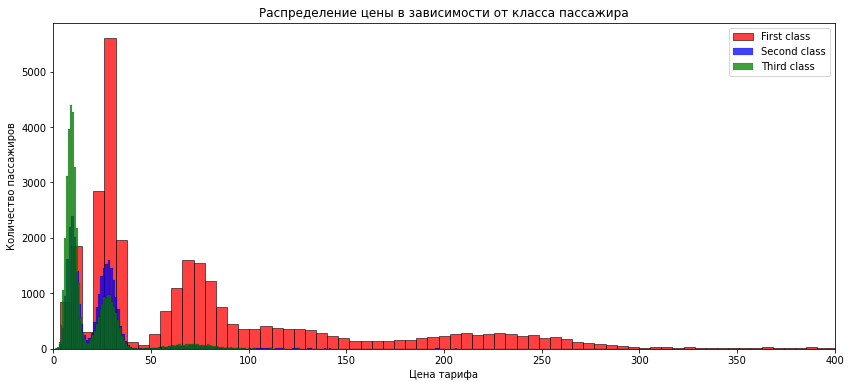

Самая частая стоимость тарифа среди пассажиров 1 класса около 29,2 класса - около 28, 3 класса - 9,5. На гистограмме имеется три ярковыраженных пика для всех трех классов, что скорее всего зависит от порта назначения


In [248]:
print('Сводка по пассажирам:\n'
      '- Среди пассажиров {:.2%} мужчин;\n'
      '- {:.2%} пассажиров 1 класса, 2 класса {:.2%} пасс., 3 класса {:.2%} пасс.'\
      .format(
      syntanic_data[syntanic_data['Sex'] == 'male'].shape[0] / total_rows,
      syntanic_data[syntanic_data['Pclass'] == 1].shape[0] / total_rows,
      syntanic_data[syntanic_data['Pclass'] == 2].shape[0] / total_rows,
      syntanic_data[syntanic_data['Pclass'] == 3].shape[0] / total_rows
))

print('- Средняя цена за тариф составляет {:.2f} (максимум {:.2f}), '
      'при этом распределение цены по классам'\
      .format(syntanic_data['Fare'].mean(),
              syntanic_data['Fare'].max()
))

plt.figure(figsize=(14, 6))
plt.title('Распределение цены в зависимости от класса пассажира')

class_price_fig: plt.Axes = sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 1]['Fare'], label='First class',
      color='Red'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 2]['Fare'], label='Second class',
      color='Blue'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 3]['Fare'], label='Third class',
      color='Green'
)

class_price_fig.set(xlabel='Цена тарифа', ylabel='Количество пассажиров')
class_price_fig.set_xlim(0, 400)
plt.legend()
plt.show()

print(f'Самая частая стоимость тарифа среди пассажиров 1 класса около 29,'
      f'2 класса - около 28, 3 класса - 9,5. На гистограмме имеется три '
      f'ярковыраженных пика для всех трех классов, что скорее всего зависит '
      f'от порта назначения')

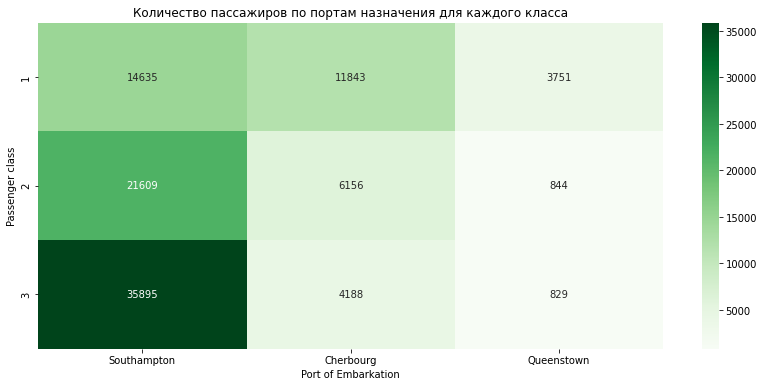

Из рисунка видно, что большинство пассажиров всех классов плыветв порт назначения Southampton


In [249]:
plt.figure(figsize=(14, 6))
plt.title('Количество пассажиров по портам назначения для каждого класса')

class_emdraked_count_data = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.uint32
)
class_emdraked_count_data.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_count_data:
      for row_index in class_emdraked_count_data[column_name].index:
          class_emdraked_count_data[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)].shape[0]

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_count_data, annot=True, fmt='.0f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

print(f'Из рисунка видно, что большинство пассажиров всех классов плывет'
      f'в порт назначения Southampton')

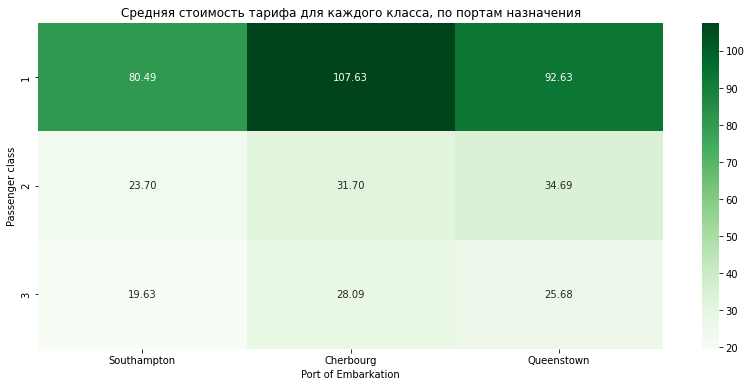

Как видно на рисунке наибольшая средняя стоимость у первого класса, при этом наибольшая средняя стоимость наблюдается для порта назначения Cherbourg (кроме 2 класса)


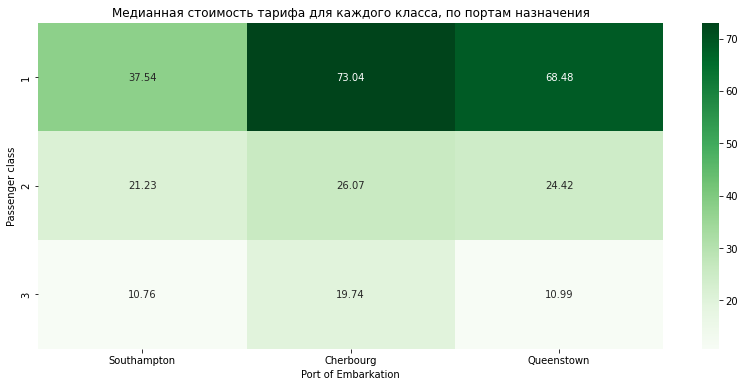

При рассмотрении медианной стоимости наблюдаются разительные отличия. В этом случае более явно видна большая стоимость тарифа до порта назначения Cherbourg. Если сделать логичное предположение, что стоимость зависит от пути, то можно сделать вывод, что путь до Cherbourg наибольший


In [250]:
class_emdraked_fare_data_mean = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_mean.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_mean:
      for row_index in class_emdraked_fare_data_mean[column_name].index:
          class_emdraked_fare_data_mean[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].mean()

class_emdraked_fare_data_median = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_median.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_median:
      for row_index in class_emdraked_fare_data_median[column_name].index:
          class_emdraked_fare_data_median[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].median()

plt.figure(figsize=(14, 6))
plt.title('Средняя стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_fare_data_mean, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

print('Как видно на рисунке наибольшая средняя стоимость у первого класса, '
      'при этом наибольшая средняя стоимость наблюдается для '
      'порта назначения Cherbourg (кроме 2 класса)')

plt.figure(figsize=(14, 6))
plt.title('Медианная стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_median = sb.heatmap(
      data=class_emdraked_fare_data_median, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_median.set_xlabel('Port of Embarkation')
plt.show()

print('При рассмотрении медианной стоимости наблюдаются разительные отличия. '
      'В этом случае более явно видна большая стоимость тарифа до '
      'порта назначения Cherbourg. Если сделать логичное предположение, что '
      'стоимость зависит от пути, то можно сделать вывод, что путь до Cherbourg '
      'наибольший')

d:\files\projects\j8ogv_rs_school_ml\rss_venv\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


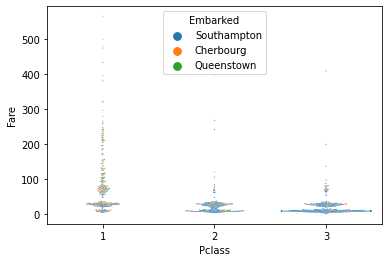

In [251]:
class_price_fig = sb.swarmplot(
      x='Pclass', y='Fare', hue='Embarked', s=1,
      data=syntanic_data[syntanic_data['Fare'].notna() & syntanic_data['Embarked'].notna()].head(1000)
)

# Summary